# Binary Classification

### 1. Importing Libraries and Reading Data

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, auc, precision_score, recall_score

import os
os.chdir('E:/PGP-DSE/Capstone Project/Group 2/OnlineNewsPopularity')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

### 2. Reading the dataset

In [37]:
df = pd.read_csv('ONPClass.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,class
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0


In [38]:
ndf = df.copy()

In [39]:
df = df.drop(['url','timedelta'],axis=1)

## 3. Custom Functions
- These functions are created as they are to be used repeatedly and to reduce the lines of code


In [57]:
# train test split
def perform_train_test_split(x,y,size):
    return train_test_split(x, y, test_size = size, random_state = 0)


# function for scaling the data for train test split
def std_data(xtrain,xtest):
    sc = StandardScaler()
    scaled = sc.fit(xtrain)
    scaled_train = sc.transform(xtrain)
    scaled_test = sc.transform(xtest)
    return scaled_train, scaled_test

# function to scale whole data
def std_data_n(x):
    sc = StandardScaler()
    scaled = sc.fit_transform(x)
    return scaled


# function to apply rfecv onto the dataset
def apply_rfecv(x,y):

    RF = RandomForestClassifier(random_state=0)
    rfecv = RFECV(estimator= RF, step = 5, cv=5, scoring='accuracy')
    rfecv.fit(x, y)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    rfe_features = pd.DataFrame({'features': x.columns, 'rank':rfecv.ranking_}).sort_values(by = 'rank')
    sel_features = rfe_features[rfe_features['rank']==1]['features'].to_list()
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return sel_features
    
# function for applying random search cv
def random_search_cv(x,y,model,params):
    RS = RandomizedSearchCV(model, params, cv = 5, scoring = 'roc_auc', random_state = 0)
    RS.fit(x,y)
    return RS.best_params_, RS.best_estimator_, RS.best_score_

# function for applying grid search cv
def grid_search_cv(x,y,model,params):
    GS = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc')
    GS.fit(x,y)
    return GS.best_params_

# creating an empty dataframe with headers
headers=['AUC Train','AUC Test','Acc Train','Acc Test','Pre Train','Pre Test','Re Train','Re Test']
dfObj = pd.DataFrame(columns = headers)


# function to get roc_auc_scores for train and test  
def fit_predict_plot(xtrain,xtest,ytrain,ytest,models):
    
    for name, model in models:
        
        model.fit(xtrain,ytrain)
        
        y_pred_train = model.predict(xtrain)
        y_pred_test = model.predict(xtest)
        
        probas_train = model.predict_proba(xtrain)[:,1]
        probas_test = model.predict_proba(xtest)[:,1]

        model_name = name 
        
        plot_roc_auc_curve(probas_train,probas_test,ytrain,ytest,name)
        
        return get_metrics(ytrain,ytest,y_pred_train,y_pred_test,probas_train,probas_test,model_name)
    
    
# function to plot the roc auc curve
def plot_roc_auc_curve(probas_train,probas_test,y_train,y_test,name):
    
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train,probas_train)

        fpr_test, tpr_test, thresholds_test = roc_curve(y_test,probas_test)

        
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        plt.plot(fpr_train, tpr_train, color='b', 
                 label=r'Train ROC (AUC = %0.2f )' % (roc_auc_score(y_train,probas_train)),lw=2, alpha=.5)
        plt.plot(fpr_test, tpr_test, color='g', 
                 label=r'Test ROC (AUC = %0.2f )' % (roc_auc_score(y_test,probas_test)),lw=2, alpha=.8)

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title('ROC of %s' % (name),fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()

        

    
# function to get all other metrics
def get_metrics(y_train,y_test,y_pred_train,y_pred_test,probas_train,probas_test,name):
        global dfObj
        print('For Train Data:\n')
        print(confusion_matrix(y_train,y_pred_train))
        #print(classification_report(y_train,y_pred_train))
        
        print('\n For Test Data:\n')
        print(confusion_matrix(y_test,y_pred_test))
        #print(classification_report(y_test,y_pred_test))

        dfObj.loc[name] = [roc_auc_score(y_train,probas_train), roc_auc_score(y_test,probas_test),
                           accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test),
                           precision_score(y_train, y_pred_train), precision_score(y_test, y_pred_test),
                           recall_score(y_train, y_pred_train), recall_score(y_test, y_pred_test)]
        return dfObj
        

# function for applying various models
def implement_cv(x,y,models):
    final = {}
    results = []
    names = []
    auc = []
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_val_score(model,x,y,cv=kfold, scoring='roc_auc')
        results.append((np.abs(cv_results)))
        auc.append(np.mean(results))
        names.append(name)
        print(cv_results)
        final.update({'Model': names , 'roc_auc_score': auc})
    return pd.DataFrame(final)


# dataframe styles
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]



In [41]:
### Get the highly correlated features

corr_val = df.corr()

correlated_features = set()
correlation_matrix = corr_val.drop('class', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)

{'LDA_02', 'n_non_stop_words', 'kw_max_max', 'kw_avg_min', 'n_non_stop_unique_tokens', 'self_reference_avg_shares'}


### 4. Implementing base model Logistic Regression


In [58]:
X = df.drop(['class','kw_max_max', 'n_non_stop_unique_tokens', 'n_non_stop_words', 'kw_avg_min', 
              'LDA_02', 'self_reference_avg_shares'],axis = 1 )

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardize the train and test sets

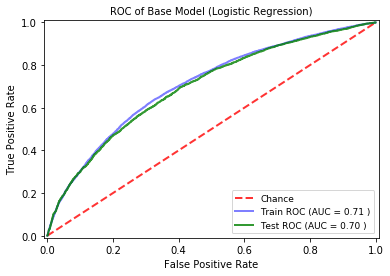

For Train Data:

[[9466 4544]
 [5000 8740]]

 For Test Data:

[[4035 2037]
 [2200 3622]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.64377,0.657934,0.640042,0.636099,0.622123


In [59]:

LOGREG = LogisticRegression(random_state = 0)

models = [('Base Model (Logistic Regression)', LOGREG)]

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

### The base model is an underfit, has high bias but manages to give high AUC value

## 5. Applying PCA on Train and Test sets

#### Custom Functions

In [44]:
# function for scaling the train and test data
def std_data_pca(xtrain,xtest):
    sc = StandardScaler()
    scaled = sc.fit(xtrain)
    scaled_train = sc.transform(xtrain)
    scaled_test = sc.transform(xtest)
    return scaled_train, scaled_test


# function to Apply PCA on train and test sets
def get_pc(train,test):
    
    # Perfroming the PCA
    pca = PCA(0.95)
    pca.fit(train)

    # Apply dimensionality reduction - PCA to standardized X and get the principal components
    pca_train = pca.transform(train)
    pca_test = pca.transform(test)
    
    # explained variance in percentage i.e (4.68/45)
    exp_var = pca.explained_variance_ratio_

    exp_var = np.round(exp_var*100,decimals=1)

    cum_var=np.cumsum(exp_var)
 
    labels = ['PC' + str(x) for x in range(1,len(exp_var)+1)]
    
    # scree plot 
    plt.figure(figsize=(20,5))
    plt.bar(x = range(1,len(exp_var)+1), height=exp_var,tick_label=labels)
    plt.xlabel('No. of  Components')
    plt.ylabel('percentage of explained variance')
    plt.title('Scree Plot')
    plt.xticks(rotation=90)
    plt.show()
    
    # Components vs Variance
    plt.figure(figsize = (5,5))
    plt.plot(cum_var)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.title('Components vs Variance')
    plt.show()

    ncomp = len(cum_var[cum_var<95])
                
    print('95% variance is explanied by {} PCs'.format(ncomp))
    
    return pca_train, pca_test

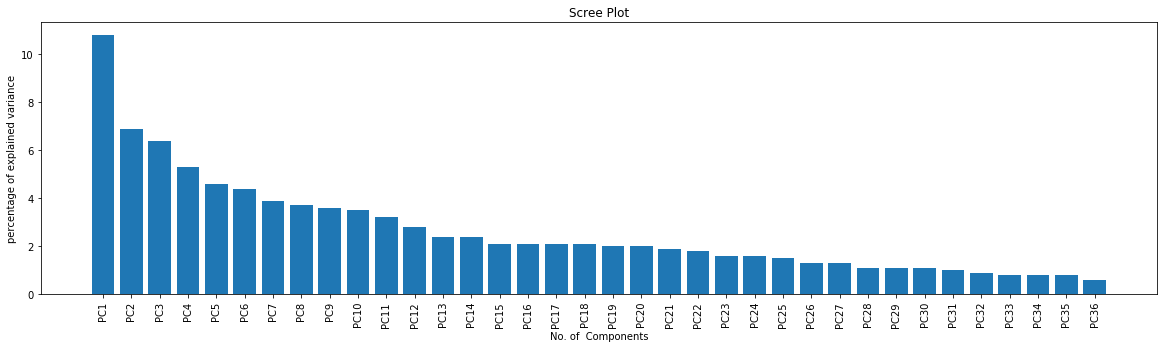

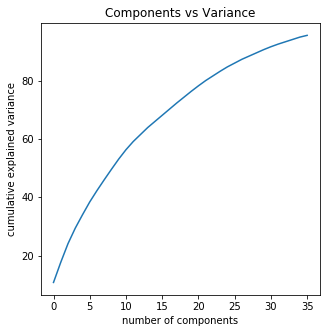

95% variance is explanied by 35 PCs


In [45]:
## Splitting the data into train and validation sets
X = df.drop(['class'], axis = 1 )

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # split

scaled_train, scaled_test = std_data_pca(X_train,X_test)    # standardize data

pca_train, pca_test = get_pc(scaled_train,scaled_test)  # apply pca

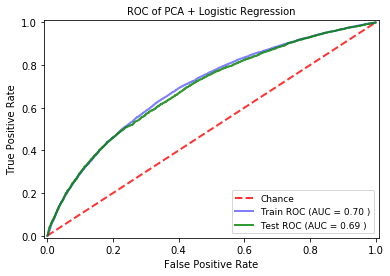

For Train Data:

[[9311 4699]
 [5126 8614]]

 For Test Data:

[[3964 2108]
 [2227 3595]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
PCA + Logistic Regression,0.695800,0.689186,0.645946,0.635531,0.647037,0.630370,0.626929,0.617485


In [46]:
## Logistic Regression

LOGREG_PCA = LogisticRegression(random_state = 0, max_iter = 1000)

models = []
models.append(('PCA + Logistic Regression',LOGREG_PCA))

fit_predict_plot(pca_train,pca_test,y_train,y_test,models)

### By applying PCA on the dataset, it is observed that there is no improvement in the model. The model is an underfit, has high bias, also a low AUC value than base model. Thus, cannot use PCA for further models.

## 6. Implementing Decision Tree

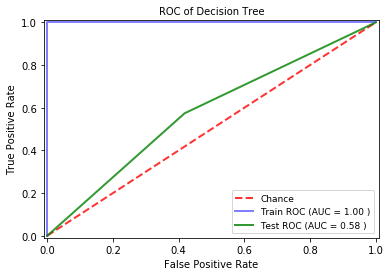

For Train Data:

[[14010     0]
 [    0 13740]]

 For Test Data:

[[3533 2539]
 [2480 3342]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
PCA + Logistic Regression,0.695800,0.689186,0.645946,0.635531,0.647037,0.630370,0.626929,0.617485
Decision Tree,1.000000,0.577940,1.000000,0.578023,1.000000,0.568271,1.000000,0.574030


In [47]:
default_DT = DecisionTreeClassifier(random_state = 0)

models = []
models.append(('Decision Tree',default_DT))

fit_predict_plot(train,test,y_train,y_test,models)

### The Decision Tree model performed worst than the base model. The values of accuracy clearly indicate the model is an overfit, has high variance.

## 7. Implementing Ensemble Models

### 7.1 Bagged Decision Tree

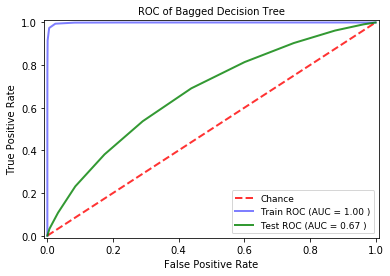

For Train Data:

[[13933    77]
 [  355 13385]]

 For Test Data:

[[4308 1764]
 [2697 3125]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
PCA + Logistic Regression,0.695800,0.689186,0.645946,0.635531,0.647037,0.630370,0.626929,0.617485
Decision Tree,1.000000,0.577940,1.000000,0.578023,1.000000,0.568271,1.000000,0.574030
Bagged Decision Tree,0.999050,0.671956,0.984432,0.624937,0.994280,0.639190,0.974163,0.536757


In [48]:
bagged_DT = BaggingClassifier( random_state = 0)

models = []
models.append(('Bagged Decision Tree',bagged_DT))

fit_predict_plot(train,test,y_train,y_test,models)

### There is slight decrease in variance 

### 7.2 Random Forest

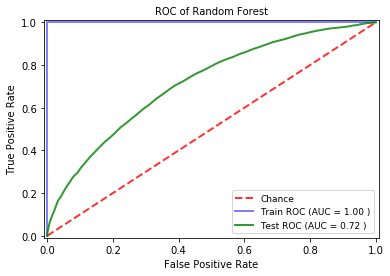

For Train Data:

[[14010     0]
 [    0 13740]]

 For Test Data:

[[4064 2008]
 [2089 3733]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
PCA + Logistic Regression,0.695800,0.689186,0.645946,0.635531,0.647037,0.630370,0.626929,0.617485
Decision Tree,1.000000,0.577940,1.000000,0.578023,1.000000,0.568271,1.000000,0.574030
Bagged Decision Tree,0.999050,0.671956,0.984432,0.624937,0.994280,0.639190,0.974163,0.536757
Random Forest,1.000000,0.716067,1.000000,0.655541,1.000000,0.650235,1.000000,0.641189


In [49]:
default_RF = RandomForestClassifier(random_state = 0)

models = []
models.append(('Random Forest',default_RF))

fit_predict_plot(train,test,y_train,y_test,models)

### The Random forest model performs better among all the models. Random Forest as well as Decision Tree  still have high variance which could be managed by tuning hyperparameters

## 8. Hyperparameter Tuning of Models

In [128]:
# Number of trees in random forest
n_estimators = np.arange(100,150,10)

# Maximum number of levels in tree
max_depth =  np.arange(3,15,3)
#[int(x) for x in np.linspace(3, 30, num = 11)]
#max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 6, 7, 8, 9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 5, 6, 7, 8]


rf_params = {'n_estimators': n_estimators, 'criterion':['gini','entropy'], 
             'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split }

default_RF = RandomForestClassifier(random_state = 0)

rfparam, rfestimator, rfscore = random_search_cv(train,y_train,default_RF,rf_params)

print('Best parameters for Random Forest are:\n', rfparam)

Best parameters for Random Forest are:
 {'n_estimators': 130, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': 9, 'criterion': 'entropy'}


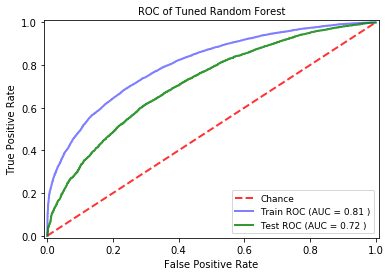

For Train Data:

[[10244  3766]
 [ 3896  9844]]

 For Test Data:

[[4013 2059]
 [2031 3791]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
PCA + Logistic Regression,0.695800,0.689186,0.645946,0.635531,0.647037,0.630370,0.626929,0.617485
Decision Tree,1.000000,0.577940,1.000000,0.578023,1.000000,0.568271,1.000000,0.574030
Bagged Decision Tree,0.999050,0.671956,0.984432,0.624937,0.994280,0.639190,0.974163,0.536757
Random Forest,1.000000,0.716067,1.000000,0.655541,1.000000,0.650235,1.000000,0.641189
Tuned Random Forest,0.805606,0.716850,0.723892,0.656129,0.723292,0.648034,0.716448,0.651151


In [50]:
tuned_RF = RandomForestClassifier(n_estimators= 130, min_samples_split = 7, 
                                  min_samples_leaf = 4,max_depth = 9, criterion = 'entropy' ,random_state = 0)

models = [('Tuned Random Forest', tuned_RF)]

fit_predict_plot(train, test, y_train, y_test, models)

In [129]:
#pd.DataFrame({'features': X.columns, 'rank': tuned_RF.feature_importances_}).sort_values(by='rank',ascending = False).head(40)

In [132]:
# Maximum number of levels in tree
max_depth =  np.arange(3,15,3)

# Minimum number of samples required to split a node
min_samples_split = [5, 6, 7, 8, 9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 5, 6, 7, 8]


dt_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf,
             'criterion':['gini','entropy'], 'min_samples_split' : min_samples_split}

dtparam, dtestimator, dtscore = random_search_cv(train,y_train,default_DT,dt_params)

print(dtparam)


{'min_samples_split': 6, 'min_samples_leaf': 8, 'max_depth': 6, 'criterion': 'entropy'}


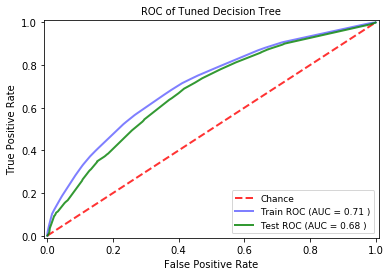

For Train Data:

[[8726 5284]
 [4354 9386]]

 For Test Data:

[[3646 2426]
 [1933 3889]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
PCA + Logistic Regression,0.695800,0.689186,0.645946,0.635531,0.647037,0.630370,0.626929,0.617485
Decision Tree,1.000000,0.577940,1.000000,0.578023,1.000000,0.568271,1.000000,0.574030
Bagged Decision Tree,0.999050,0.671956,0.984432,0.624937,0.994280,0.639190,0.974163,0.536757
Random Forest,1.000000,0.716067,1.000000,0.655541,1.000000,0.650235,1.000000,0.641189
Tuned Random Forest,0.805606,0.716850,0.723892,0.656129,0.723292,0.648034,0.716448,0.651151
Tuned Decision Tree,0.707421,0.677539,0.652685,0.633513,0.639809,0.615835,0.683115,0.667984


In [51]:
tuned_DT =  DecisionTreeClassifier( min_samples_split = 6, 
                                  min_samples_leaf = 8, max_depth = 6, criterion = 'entropy' ,random_state = 0)
models  = []
models = [('Tuned Decision Tree', tuned_DT)]
fit_predict_plot(train, test, y_train, y_test,models)

## Feature Selection using RFE

In [31]:

X = df.drop(['class','kw_max_max', 'n_non_stop_unique_tokens', 'n_non_stop_words', 'kw_avg_min', 
              'LDA_02', 'self_reference_avg_shares'],axis = 1 )

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardize the train and test sets


In [33]:
X_train.shape

(27750, 52)

Optimal number of features : 47


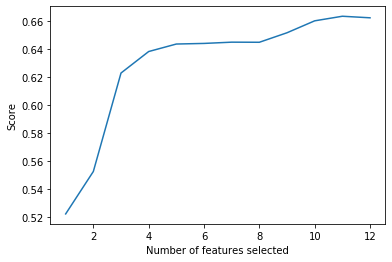

In [32]:
sel_features = apply_rfecv(X_train,y_train)

In [35]:
print(sel_features)

['n_tokens_title', 'weekday_is_thursday', 'weekday_is_saturday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'weekday_is_wednesday', 'abs_title_subjectivity', 'weekday_is_tuesday', 'self_reference_max_shares', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_entertainment', 'data_channel_is_tech', 'data_channel_is_socmed', 'kw_min_min', 'kw_max_min', 'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'data_channel_is_world', 'abs_title_sentiment_polarity']


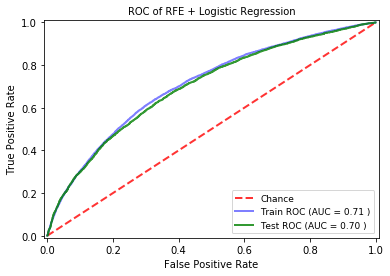

For Train Data:

[[9453 4557]
 [4999 8741]]

 For Test Data:

[[4035 2037]
 [2181 3641]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
RFE + Logistic Regression,0.706229,0.697644,0.655640,0.645367,0.657317,0.641247,0.636172,0.625386


In [60]:
X = df[sel_features]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardize the train and test sets


RFE_LOGREG = LogisticRegression(random_state = 0)

models = [('RFE + Logistic Regression', RFE_LOGREG)]

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

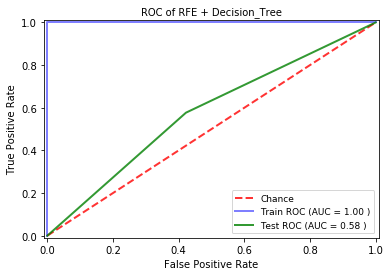

For Train Data:

[[14010     0]
 [    0 13740]]

 For Test Data:

[[3508 2564]
 [2463 3359]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
RFE + Logistic Regression,0.706229,0.697644,0.655640,0.645367,0.657317,0.641247,0.636172,0.625386
RFE + Decision_Tree,1.000000,0.577342,1.000000,0.577350,1.000000,0.567111,1.000000,0.576950


In [61]:
RFE_DT = DecisionTreeClassifier(random_state = 0)

models = []
models.append(('RFE + Decision_Tree',RFE_DT))

fit_predict_plot(train,test,y_train,y_test,models)

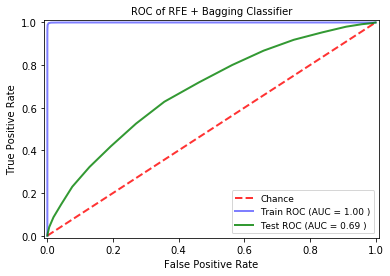

For Train Data:

[[13958    52]
 [   42 13698]]

 For Test Data:

[[3908 2164]
 [2164 3658]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
RFE + Logistic Regression,0.706229,0.697644,0.655640,0.645367,0.657317,0.641247,0.636172,0.625386
RFE + Decision_Tree,1.000000,0.577342,1.000000,0.577350,1.000000,0.567111,1.000000,0.576950
RFE + Bagging Classifier,0.999932,0.685058,0.996613,0.636119,0.996218,0.628306,0.996943,0.628306


In [66]:
RFE_bagging = BaggingClassifier(base_estimator = RFE_DT, n_estimators = 17, random_state = 0)

models = []
models.append(('RFE + Bagging Classifier',RFE_bagging))

fit_predict_plot(train,test,y_train,y_test,models)

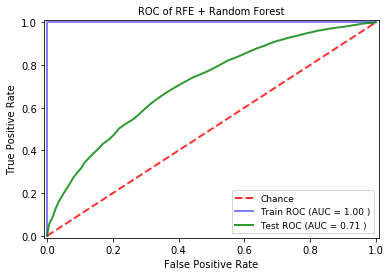

For Train Data:

[[14010     0]
 [    0 13740]]

 For Test Data:

[[4036 2036]
 [2081 3741]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
RFE + Logistic Regression,0.706229,0.697644,0.655640,0.645367,0.657317,0.641247,0.636172,0.625386
RFE + Decision_Tree,1.000000,0.577342,1.000000,0.577350,1.000000,0.567111,1.000000,0.576950
RFE + Bagging Classifier,0.999932,0.685058,0.996613,0.636119,0.996218,0.628306,0.996943,0.628306
RFE + Random Forest,1.000000,0.711958,1.000000,0.653859,1.000000,0.647568,1.000000,0.642563


In [67]:
RFE_RF = RandomForestClassifier(random_state = 0)

models = []
models.append(('RFE + Random Forest',RFE_RF))

fit_predict_plot(train,test,y_train,y_test,models)

In [68]:
## Hyperparameter Tuning of Models

# Number of trees in random forest
n_estimators = np.arange(100,150,10)

# Maximum number of levels in tree
max_depth =  np.arange(3,20,4)
#[int(x) for x in np.linspace(3, 30, num = 11)]
#max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 6, 7, 8, 9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 5, 6, 7, 8]


rf_params = {'n_estimators': n_estimators, 'criterion':['gini','entropy'], 
             'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split }

RFE_RF = RandomForestClassifier(random_state = 0)

rfparam, rfestimator, rfscore = random_search_cv(train,y_train,RFE_RF,rf_params)

print('Best parameters for Random Forest are:\n', rfparam)



Best parameters for Random Forest are:
 {'n_estimators': 140, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_depth': 15, 'criterion': 'entropy'}


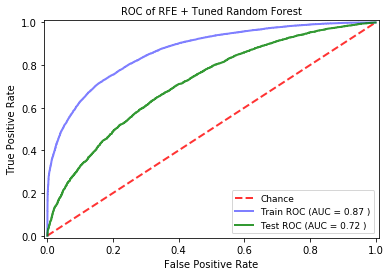

For Train Data:

[[11031  2979]
 [ 3188 10552]]

 For Test Data:

[[4037 2035]
 [2037 3785]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
RFE + Logistic Regression,0.706229,0.697644,0.655640,0.645367,0.657317,0.641247,0.636172,0.625386
RFE + Decision_Tree,1.000000,0.577342,1.000000,0.577350,1.000000,0.567111,1.000000,0.576950
RFE + Bagging Classifier,0.999932,0.685058,0.996613,0.636119,0.996218,0.628306,0.996943,0.628306
RFE + Random Forest,1.000000,0.711958,1.000000,0.653859,1.000000,0.647568,1.000000,0.642563
RFE + Tuned Random Forest,0.867871,0.717997,0.777766,0.657643,0.779839,0.650344,0.767977,0.650120
RFE + Tuned Decision Tree,0.707421,0.677539,0.652685,0.633513,0.639809,0.615835,0.683115,0.667984
AdaBoost Tuned DT,0.814744,0.671233,0.727351,0.630990,0.730614,0.624457,0.711790,0.617485
AdaBoost Tuned RF,1.000000,0.721379,1.000000,0.658735,1.000000,0.652799,1.000000,0.646857


In [81]:
RFE_tuned_RF = RandomForestClassifier(n_estimators= 130, min_samples_split = 7, min_samples_leaf = 4,
                                      max_depth = 11, criterion = 'entropy' ,random_state = 0)

models = [('RFE + Tuned Random Forest', RFE_tuned_RF)]

fit_predict_plot(train, test, y_train, y_test, models)

#pd.DataFrame({'features': X.columns, 'rank': tuned_RF.feature_importances_}).sort_values(by='rank',ascending = False).head(40)




In [70]:

# Maximum number of levels in tree
max_depth =  np.arange(3,15,3)

# Minimum number of samples required to split a node
min_samples_split = [5, 6, 7, 8, 9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 5, 6, 7, 8]


dt_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf,
             'criterion':['gini','entropy'], 'min_samples_split' : min_samples_split}

dtparam, dtestimator, dtscore = random_search_cv(train,y_train,RFE_DT,dt_params)

print(dtparam)



{'min_samples_split': 6, 'min_samples_leaf': 8, 'max_depth': 6, 'criterion': 'entropy'}


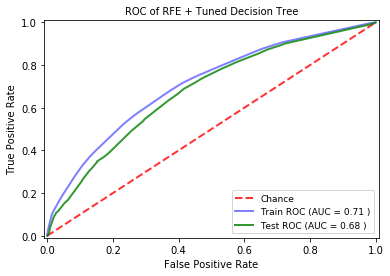

For Train Data:

[[8726 5284]
 [4354 9386]]

 For Test Data:

[[3646 2426]
 [1933 3889]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
RFE + Logistic Regression,0.706229,0.697644,0.655640,0.645367,0.657317,0.641247,0.636172,0.625386
RFE + Decision_Tree,1.000000,0.577342,1.000000,0.577350,1.000000,0.567111,1.000000,0.576950
RFE + Bagging Classifier,0.999932,0.685058,0.996613,0.636119,0.996218,0.628306,0.996943,0.628306
RFE + Random Forest,1.000000,0.711958,1.000000,0.653859,1.000000,0.647568,1.000000,0.642563
RFE + Tuned Random Forest,0.940474,0.722167,0.858631,0.661006,0.862064,0.653096,0.850582,0.655788
RFE + Tuned Decision Tree,0.707421,0.677539,0.652685,0.633513,0.639809,0.615835,0.683115,0.667984


In [71]:

RFE_tuned_DT =  dtestimator
#DecisionTreeClassifier( min_samples_split = 6, min_samples_leaf = 8, max_depth = 6, criterion = 'entropy' ,random_state = 0)
models  = []
models = [('RFE + Tuned Decision Tree', RFE_tuned_DT)]
fit_predict_plot(train, test, y_train, y_test,models)



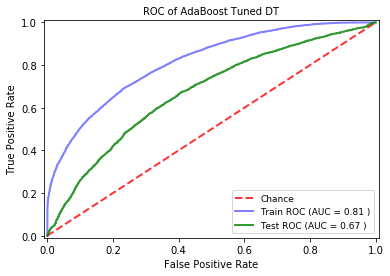

For Train Data:

[[10404  3606]
 [ 3960  9780]]

 For Test Data:

[[3910 2162]
 [2227 3595]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Base Model (Logistic Regression),0.706602,0.697556,0.656072,0.643770,0.657934,0.640042,0.636099,0.622123
RFE + Logistic Regression,0.706229,0.697644,0.655640,0.645367,0.657317,0.641247,0.636172,0.625386
RFE + Decision_Tree,1.000000,0.577342,1.000000,0.577350,1.000000,0.567111,1.000000,0.576950
RFE + Bagging Classifier,0.999932,0.685058,0.996613,0.636119,0.996218,0.628306,0.996943,0.628306
RFE + Random Forest,1.000000,0.711958,1.000000,0.653859,1.000000,0.647568,1.000000,0.642563
RFE + Tuned Random Forest,0.940474,0.722167,0.858631,0.661006,0.862064,0.653096,0.850582,0.655788
RFE + Tuned Decision Tree,0.707421,0.677539,0.652685,0.633513,0.639809,0.615835,0.683115,0.667984
AdaBoost Tuned DT,0.814744,0.671233,0.727351,0.630990,0.730614,0.624457,0.711790,0.617485


In [74]:
AB_RFE_DT = AdaBoostClassifier(base_estimator = RFE_tuned_DT, n_estimators = 15,random_state=0)

models = []
models.append(('AdaBoost Tuned DT', AB_RFE_DT))

fit_predict_plot(train, test, y_train, y_test,models)

## Evaluation  of the models

In [25]:
LOGREG = LogisticRegression(random_state = 0, max_iter = 2000)
default_DT = DecisionTreeClassifier(random_state = 0)
bagged_DT = BaggingClassifier( random_state = 0)
default_RF = RandomForestClassifier(random_state = 0)

all_models = []
all_models.append(('Logistic Regression',LOGREG))
all_models.append(('Decision Tree',default_DT))
all_models.append(('Bagged Decision Tree',bagged_DT))
all_models.append(('Random Forest',default_RF))

implement_cv(X,Y,all_models)

C:\Users\Ankita\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ankita\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

[0.63887105 0.63181567 0.6391571  0.63149467 0.64248429]
[0.5776926  0.57558614 0.57592342 0.57234452 0.57965147]
[0.6679468  0.66525861 0.67972606 0.67418184 0.68278672]
[0.71423795 0.71657688 0.72333634 0.72382344 0.73368225]


,Model,roc_auc_score
0,Logistic Regression,0.636765
1,Decision Tree,0.606502
2,Bagged Decision Tree,0.628995
3,Random Forest,0.652329


## Feature Engineering

In [160]:
import re
ndf['date_published'] = ndf['url'].apply(lambda x: (re.search(r"[0-9].../[0-9]./[0-9].",x)).group())
ndf['date_published'] = pd.to_datetime(ndf['date_published'])
ndf['month'] = pd.DatetimeIndex(ndf['date_published']).month

In [138]:
ndf = ndf.drop(['url','timedelta','date_published'],axis=1)

In [139]:
lda = ['LDA_00','LDA_01','LDA_02','LDA_03','LDA_04']

lda_max = ndf[lda].max(axis=1)

lda_topic = ndf[lda].idxmax(axis=1)

all_lda_articles = pd.DataFrame({'topic': lda_topic, 'val': lda_max})

ndf['topic'] = all_lda_articles['topic'] 

ndf = ndf.drop(lda,axis = 1)

In [140]:
ndf = pd.get_dummies(ndf,prefix = 'topic')

In [141]:
ndf.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,class,month,topic_LDA_00,topic_LDA_01,topic_LDA_02,topic_LDA_03,topic_LDA_04
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,-0.187500,0.000000,0.187500,0,1,1,0,0,0,0
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.000000,0.500000,0.000000,0,1,1,0,0,0,0
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.000000,0.500000,0.000000,1,1,0,0,0,0,1
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.000000,0.500000,0.000000,0,1,0,0,1,0,0
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.136364,0.045455,0.136364,0,1,0,0,0,0,1


## Comaprison of Models

In [192]:
final_scores = dfObj

final_scores.columns = ['Train','Test','Train','Test','Train','Test','Train','Test']

headers = pd.MultiIndex.from_product([['ROC_AUC','ACCURACY','PRECISION','RECALL'],['Train','Test']])

final_scores.columns = headers

final_scores.style.set_table_styles(styles)

(                                     Train      Test
 Base Model (Logistic Regression)  0.655928  0.643434
 PCA + Logistic Regression         0.645946  0.635531
 Decision Tree                     1.000000  0.584244
 Bagged Decision Tree              0.983856  0.614932
 Random Forest                     1.000000  0.655288
 Tuned Random Forest               0.773369  0.658567,
 <matplotlib.axes._subplots.AxesSubplot at 0x2eed2a0c848>)

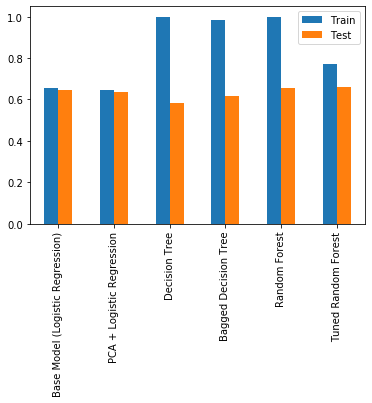

In [63]:
final_scores['ACCURACY'], final_scores['ACCURACY'].plot(kind ='bar')